In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install scorecardpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.7-py3-none-any.whl size=60634 sha256=583815182fe68789bc7fedb2fce1ce2a13d76f52e4d31df8e084ffd6f83e9947
  Stored in directory: /root/.cache/pip/wheels/49/49/e9/7b845548eed3624ce37effdd13e9cb95a99272d692eb9e9e23
Successfully built scorecardpy


In [4]:
import scorecardpy as sc

In [5]:
import pandas.core.algorithms as algos
import scipy.stats.stats as stats
import traceback
import string
import statsmodels
import re
import mlxtend

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import time
import warnings
warnings.filterwarnings("ignore")

In [7]:
data = pd.read_csv('/content/drive/MyDrive/Năm 3/Risk Analyst/data_after_handling.csv')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99997 entries, 0 to 99996
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_CURR                   99997 non-null  int64  
 1   TARGET                       99997 non-null  int64  
 2   NAME_CONTRACT_TYPE           99997 non-null  object 
 3   CODE_GENDER                  99997 non-null  object 
 4   FLAG_OWN_CAR                 99997 non-null  object 
 5   FLAG_OWN_REALTY              99997 non-null  object 
 6   CNT_CHILDREN                 99997 non-null  int64  
 7   AMT_INCOME_TOTAL             99997 non-null  float64
 8   AMT_CREDIT                   99997 non-null  float64
 9   AMT_ANNUITY                  99997 non-null  float64
 10  AMT_GOODS_PRICE              99997 non-null  float64
 11  NAME_TYPE_SUITE              99997 non-null  object 
 12  NAME_INCOME_TYPE             99997 non-null  object 
 13  NAME_EDUCATION_T

# Drop column has IV < 0.02

In [8]:
max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):

    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin
        bins = np.linspace(notmiss.X.min(), notmiss.X.max(), n+1)
        # bins = notmiss.X.quantile(np.linspace(0, 1, n))
        # if len(np.unique(bins)) == 2:
        #     bins = np.insert(bins, 0, 1)
        #     bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, bins,include_lowest=True)})
        d2 = d1.groupby('Bucket', as_index=True)

    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = pd.concat([d3, d4], ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()

    return(d3)

def char_bin(Y, X):

    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    df2 = notmiss.groupby('X',as_index=True)

    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y

    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = pd.concat([d3, d4], ignore_index=True)

    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)

    return(d3)

def data_vars(df1, target):

    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]

    x = df1.dtypes.index
    count = -1

    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(pd.Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1

            if count == 0:
                iv_df = conv
            else:
                iv_df = pd.concat([iv_df, conv], ignore_index=True)

    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [9]:
final_iv, IV = data_vars(data.drop(columns =["SK_ID_CURR", 'TARGET']), data["TARGET"])

In [10]:
IV[IV['IV'] < 0.02]["VAR_NAME"].values


array(['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'DAYS_REGISTRATION',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE',
       'HOUR_APPR_PROCESS_START', 'NAME_CONTRACT_TYPE',
       'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'WEEKDAY_APPR_PROCESS_START'],
      dtype=object)

In [11]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,NAME_CONTRACT_TYPE,Cash loans,Cash loans,90517,7562,0.083542,82955,0.916458,0.934388,0.902627,0.034582,0.013637
1,NAME_CONTRACT_TYPE,Revolving loans,Revolving loans,9480,531,0.056013,8949,0.943987,0.065612,0.097373,-0.394790,0.013637
2,CODE_GENDER,F,F,65855,4615,0.070078,61240,0.929922,0.570246,0.666347,-0.155744,0.039292
3,CODE_GENDER,M,M,34142,3478,0.101869,30664,0.898131,0.429754,0.333653,0.253113,0.039292
4,FLAG_OWN_CAR,N,N,66016,5601,0.084843,60415,0.915157,0.692080,0.657371,0.051453,0.005493
...,...,...,...,...,...,...,...,...,...,...,...,...
242,AMT_REQ_CREDIT_BUREAU_QRT,3.0,5.0,741,58,0.078273,683,0.921727,0.007167,0.007432,-0.036307,0.000056
243,AMT_REQ_CREDIT_BUREAU_QRT,6.0,8.0,16,2,0.125000,14,0.875000,0.000247,0.000152,0.483835,0.000056
244,AMT_REQ_CREDIT_BUREAU_YEAR,0.0,8.0,99576,8050,0.080843,91526,0.919157,0.994687,0.995887,-0.001206,0.000357
245,AMT_REQ_CREDIT_BUREAU_YEAR,9.0,16.0,416,42,0.100962,374,0.899038,0.005190,0.004069,0.243159,0.000357


In [12]:
low_IV_cols = ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_YEAR',
       'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'DAYS_REGISTRATION',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'FLAG_MOBIL', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE',
       'HOUR_APPR_PROCESS_START', 'NAME_CONTRACT_TYPE',
       'NAME_HOUSING_TYPE', 'NAME_TYPE_SUITE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'WEEKDAY_APPR_PROCESS_START']

# WOE Binning

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
ORGANIZATION_TYPE
>>> Continue the binning process?
1: yes 
2: no
Selection: 1
Binning on 99997 rows and 43 columns in 00:00:39


{'REGION_RATING_CLIENT_W_CITY': <Figure size 640x480 with 2 Axes>,
 'AMT_REQ_CREDIT_BUREAU_WEEK': <Figure size 640x480 with 2 Axes>,
 'DAYS_BIRTH': <Figure size 640x480 with 2 Axes>,
 'AMT_CREDIT': <Figure size 640x480 with 2 Axes>,
 'FLAG_MOBIL': <Figure size 640x480 with 2 Axes>,
 'NAME_EDUCATION_TYPE': <Figure size 640x480 with 2 Axes>,
 'FLAG_WORK_PHONE': <Figure size 640x480 with 2 Axes>,
 'AMT_GOODS_PRICE': <Figure size 640x480 with 2 Axes>,
 'REGION_RATING_CLIENT': <Figure size 640x480 with 2 Axes>,
 'NAME_HOUSING_TYPE': <Figure size 640x480 with 2 Axes>,
 'AMT_REQ_CREDIT_BUREAU_HOUR': <Figure size 640x480 with 2 Axes>,
 'DAYS_LAST_PHONE_CHANGE': <Figure size 640x480 with 2 Axes>,
 'NAME_TYPE_SUITE': <Figure size 640x480 with 2 Axes>,
 'AMT_REQ_CREDIT_BUREAU_YEAR': <Figure size 640x480 with 2 Axes>,
 'FLAG_OWN_CAR': <Figure size 640x480 with 2 Axes>,
 'OBS_60_CNT_SOCIAL_CIRCLE': <Figure size 640x480 with 2 Axes>,
 'AMT_REQ_CREDIT_BUREAU_MON': <Figure size 640x480 with 2 Axes>,
 

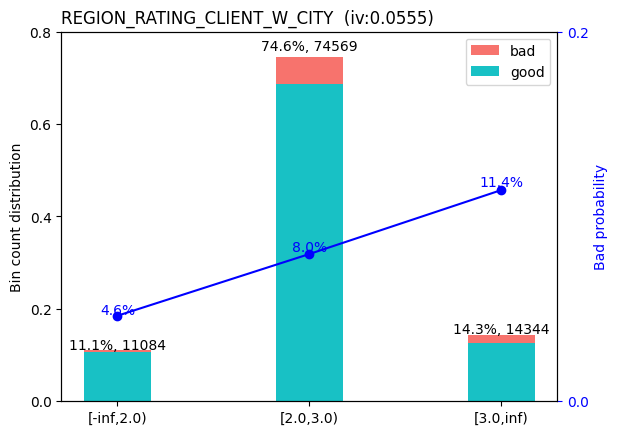

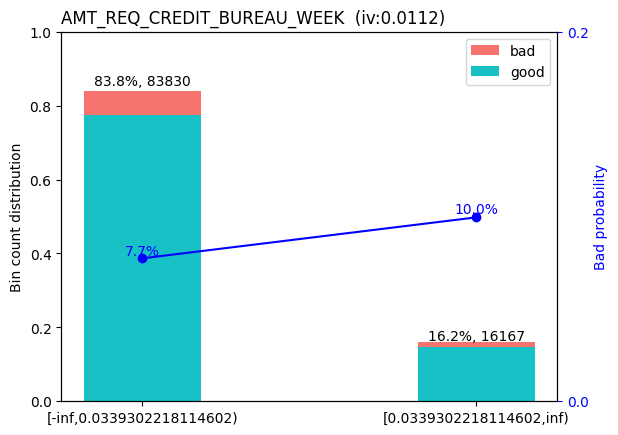

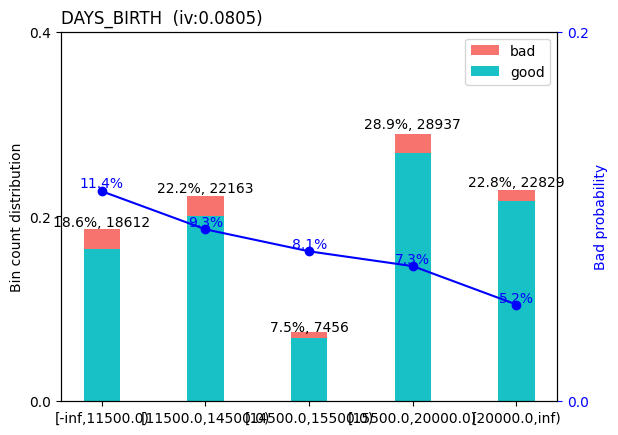

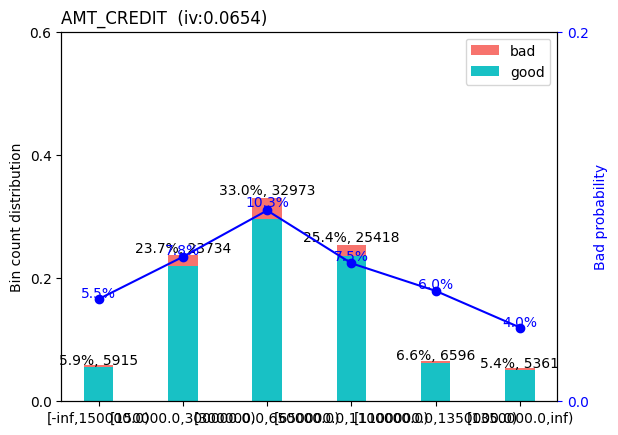

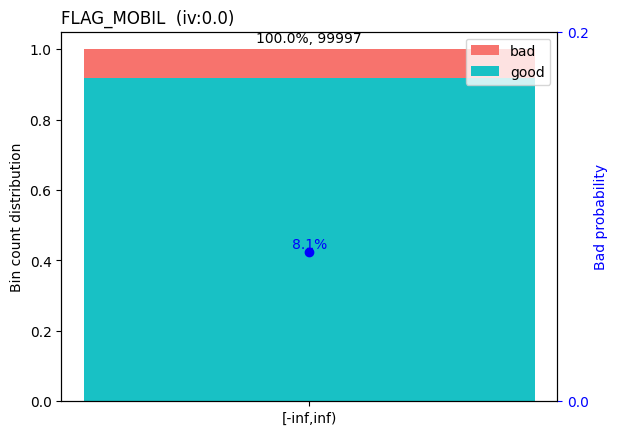

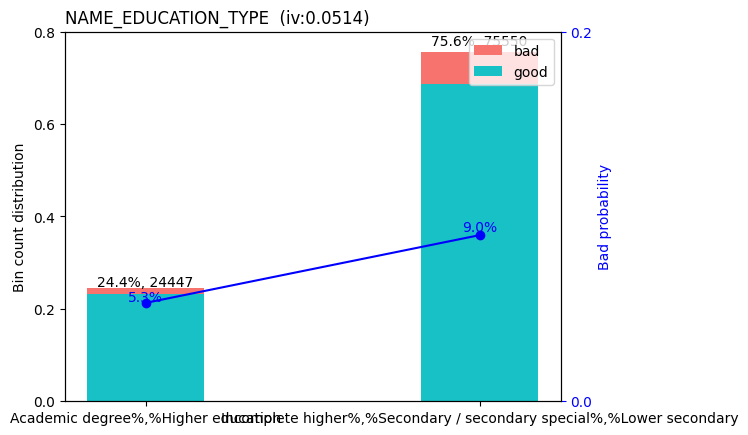

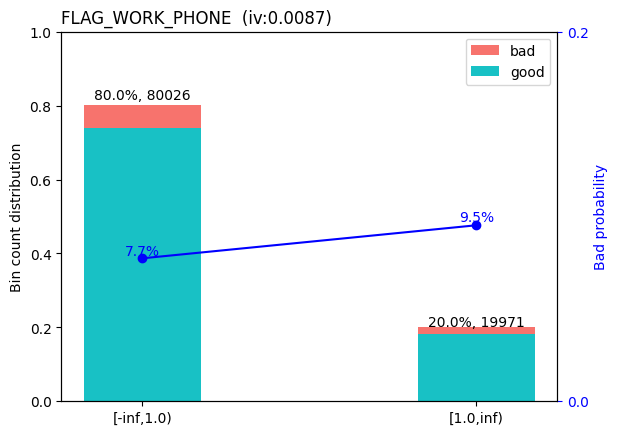

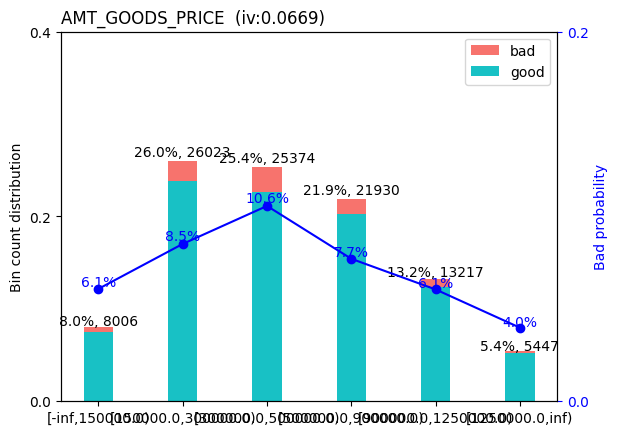

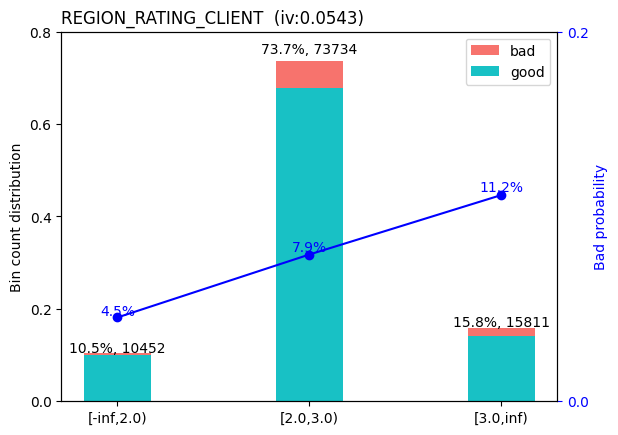

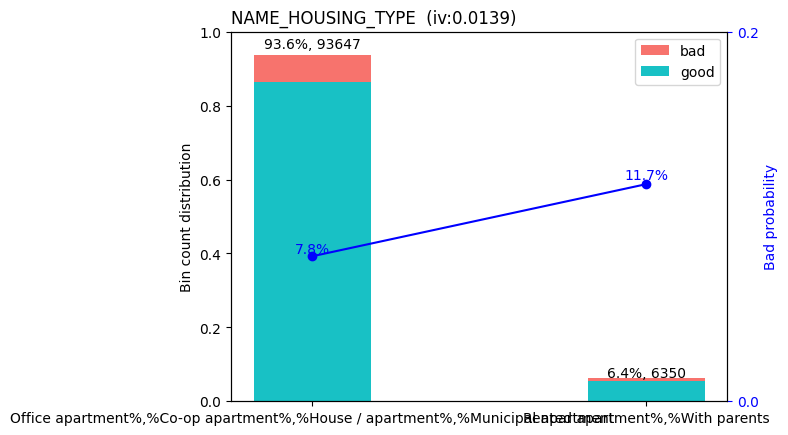

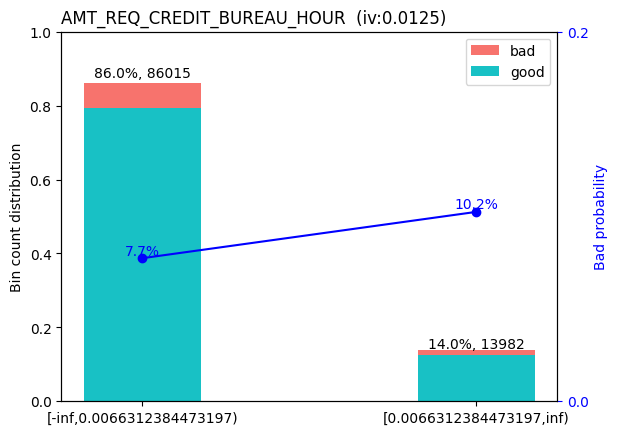

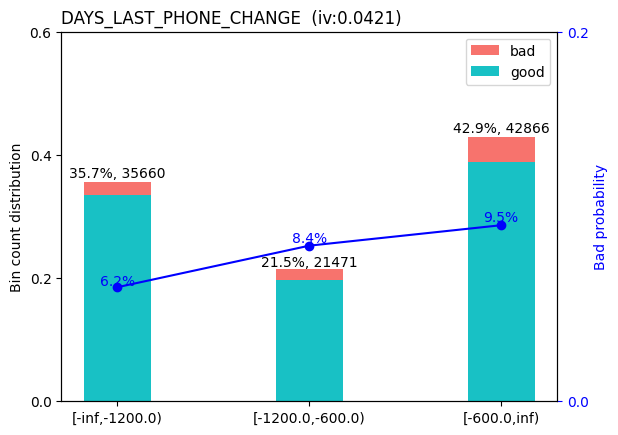

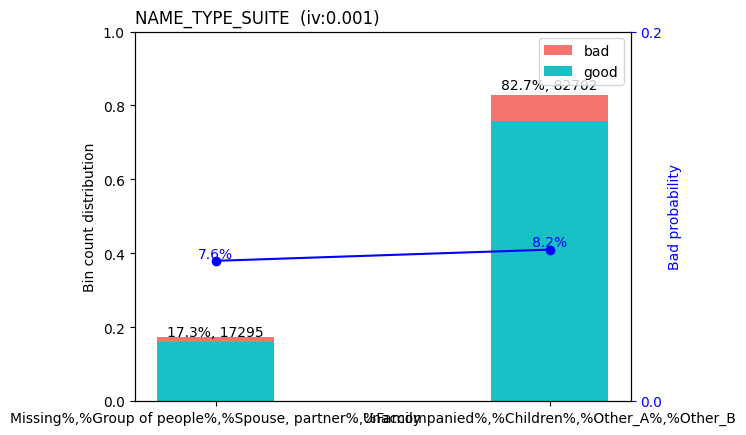

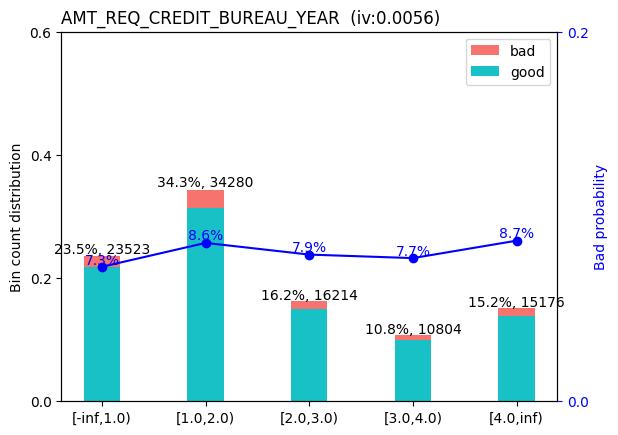

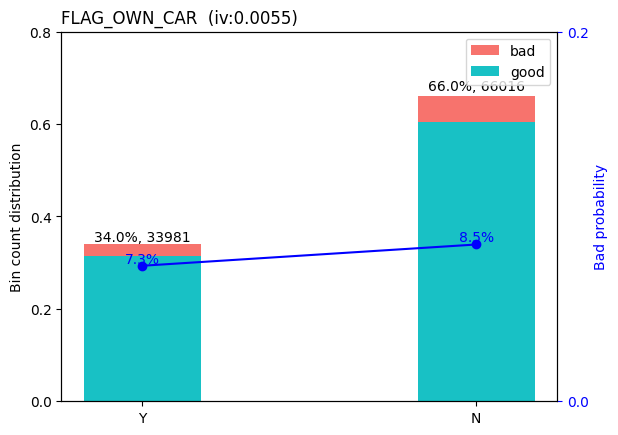

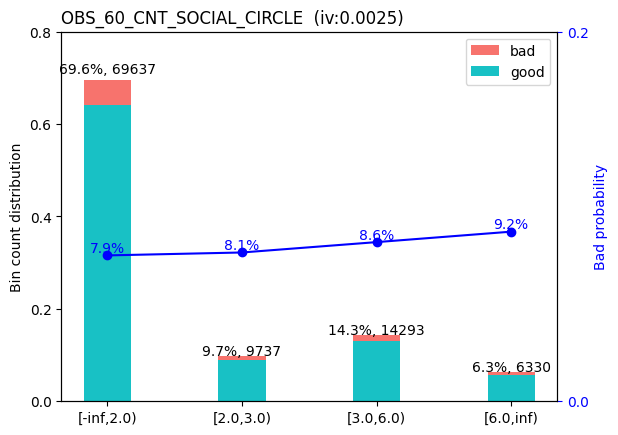

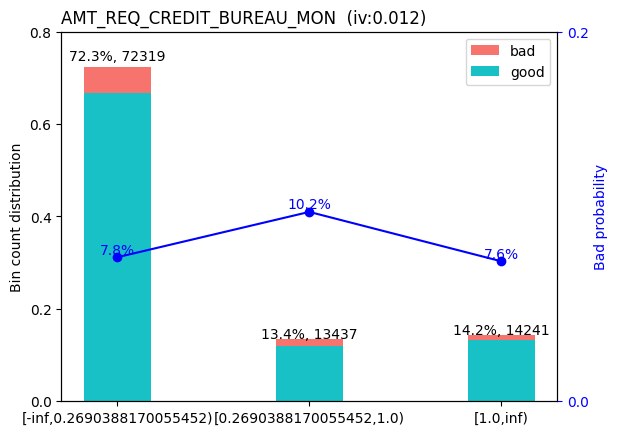

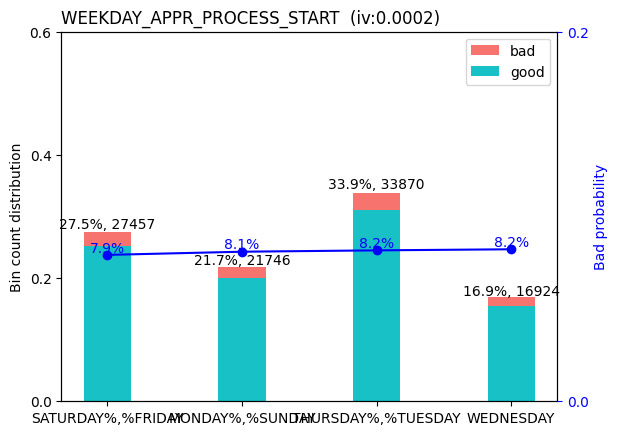

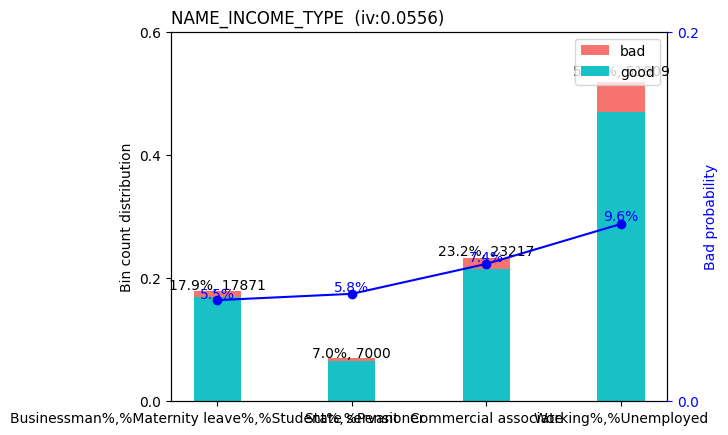

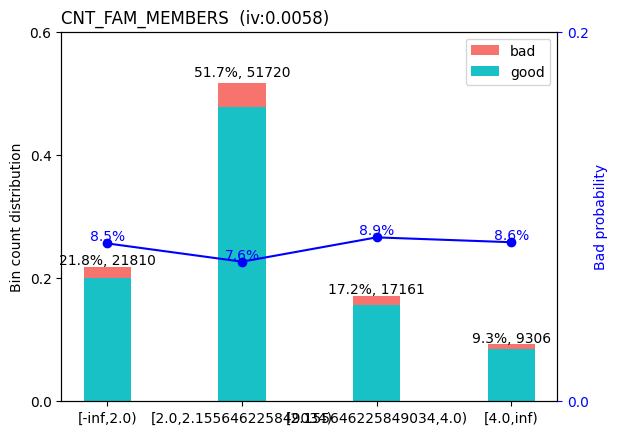

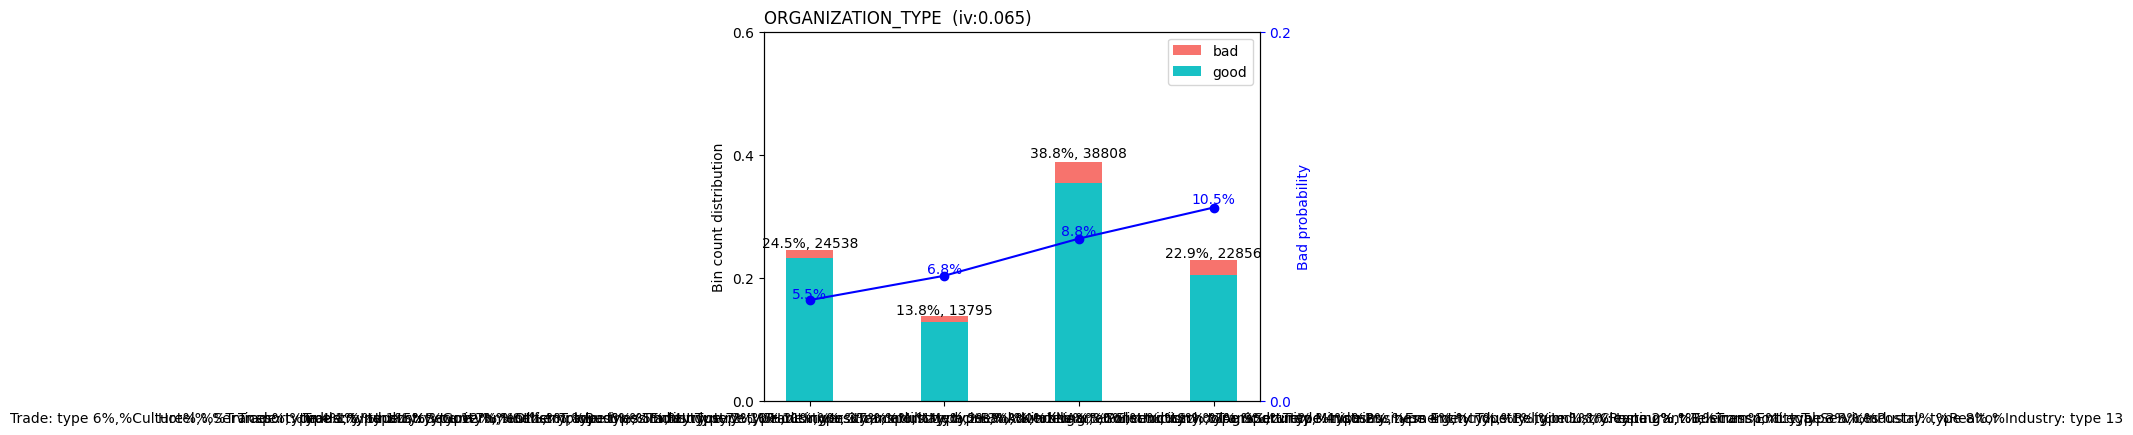

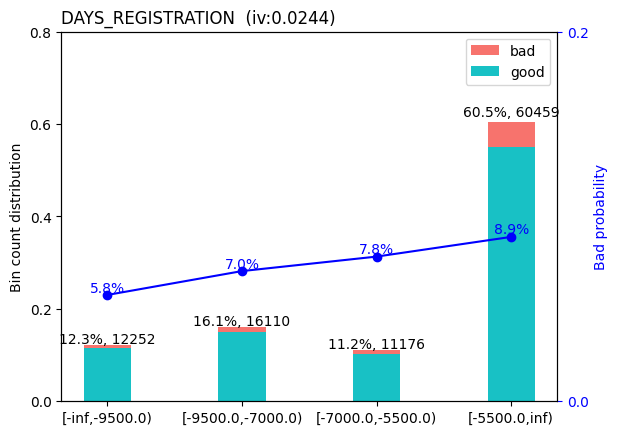

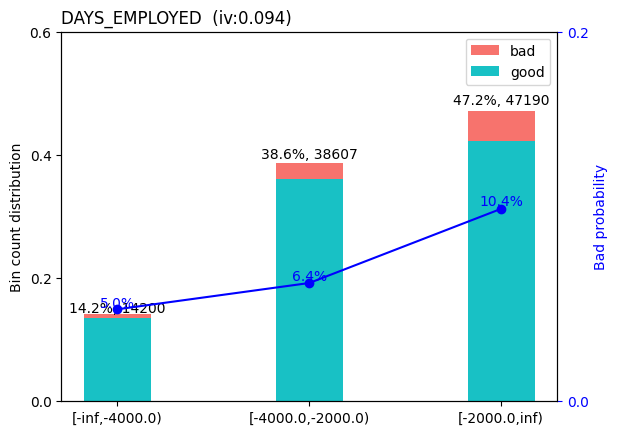

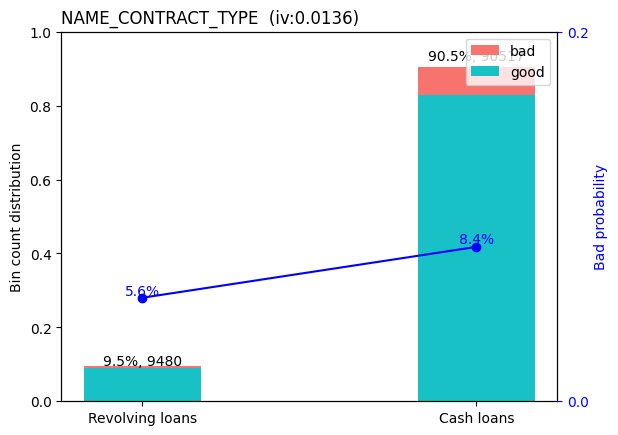

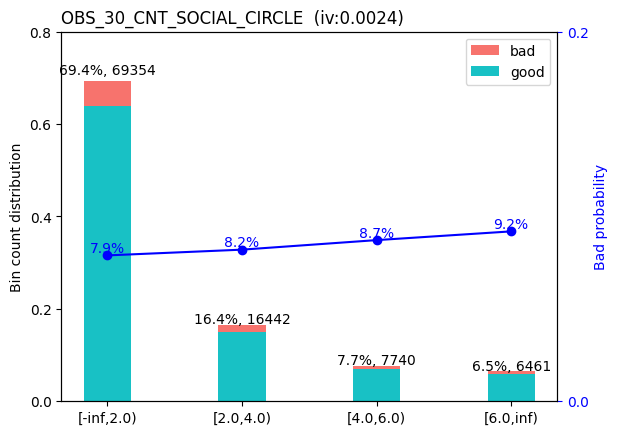

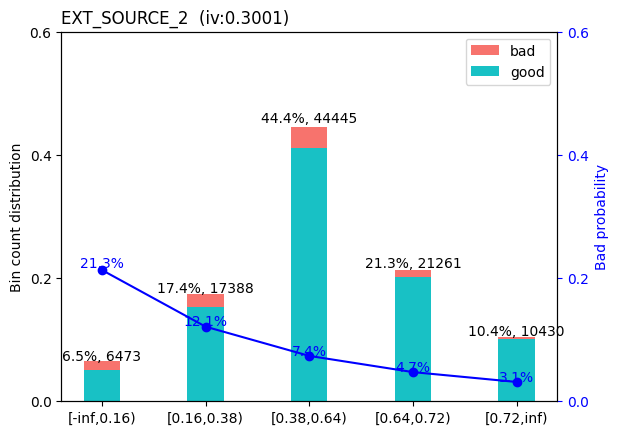

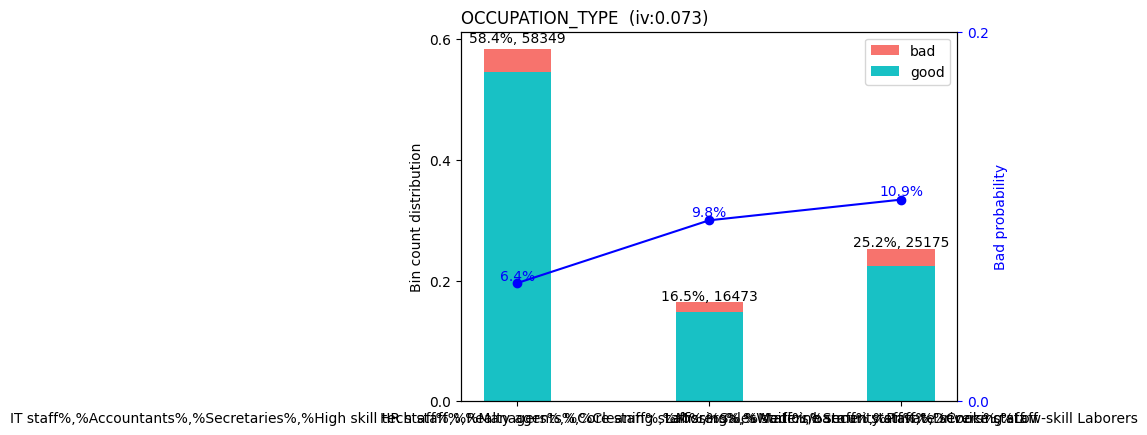

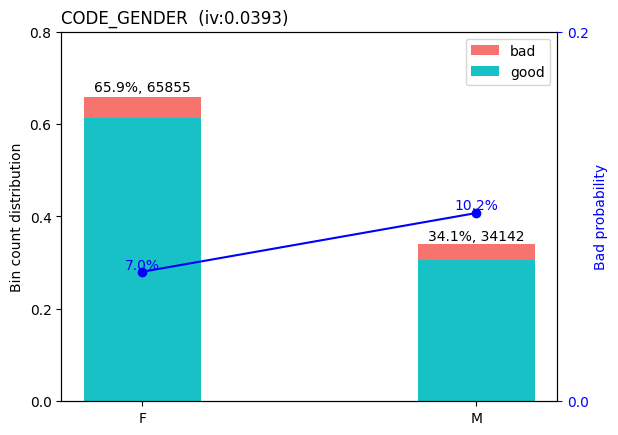

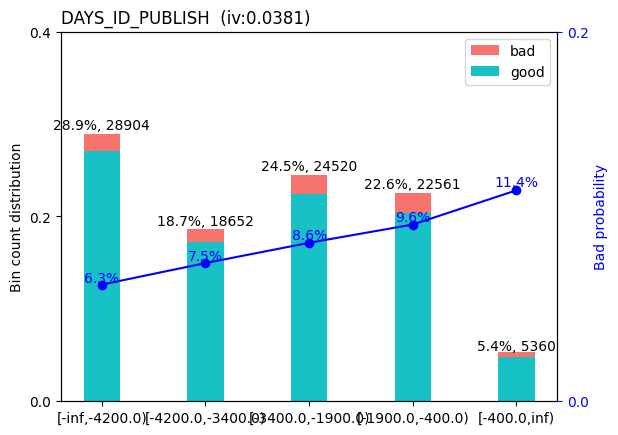

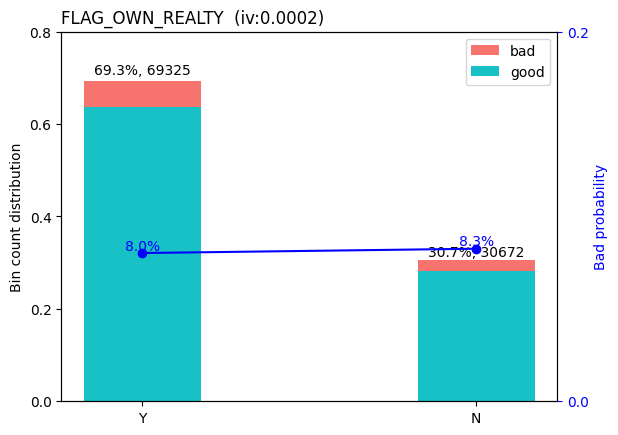

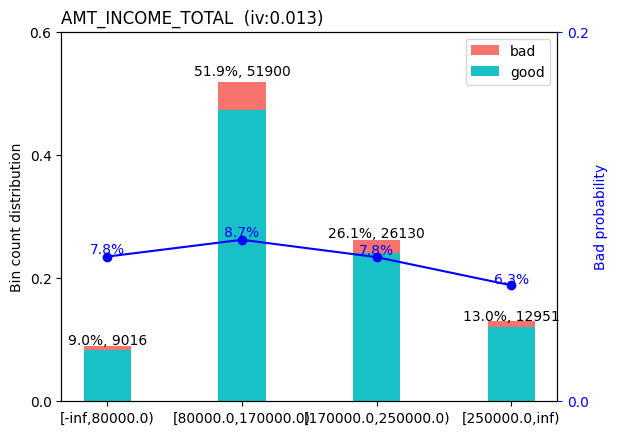

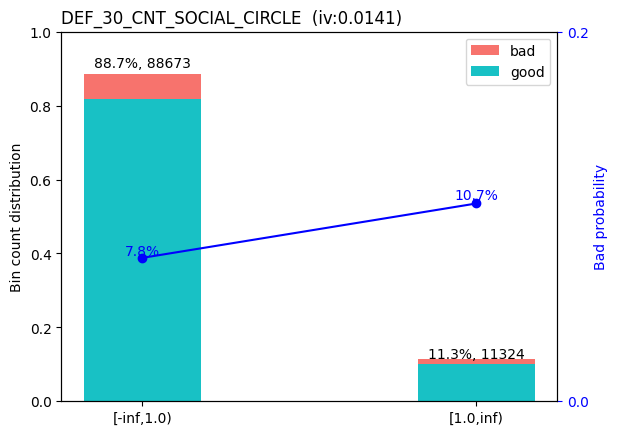

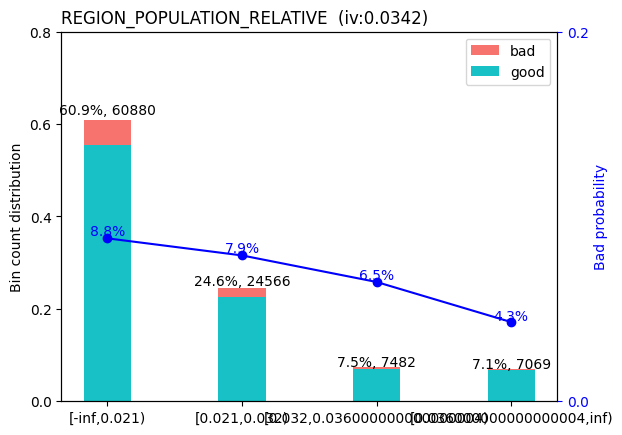

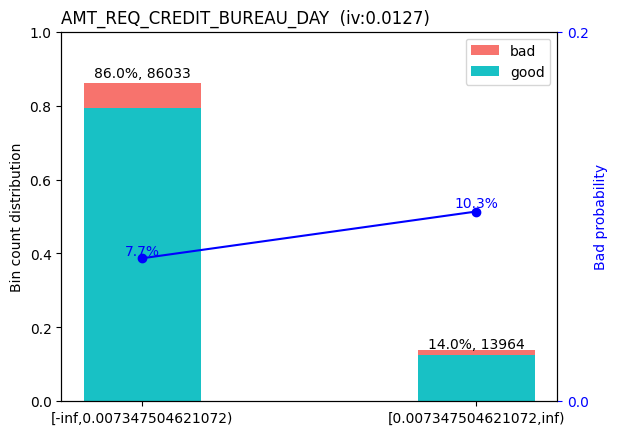

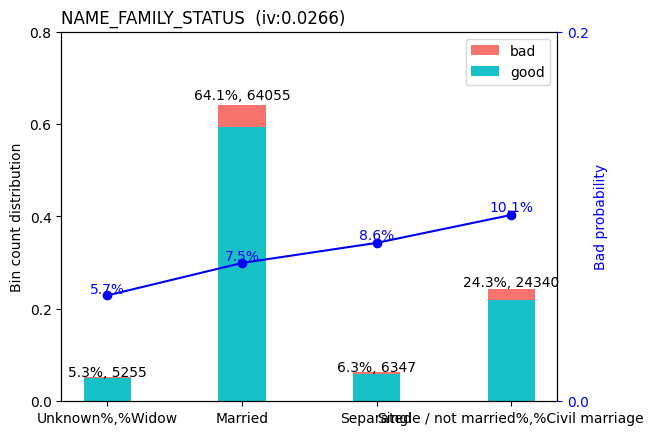

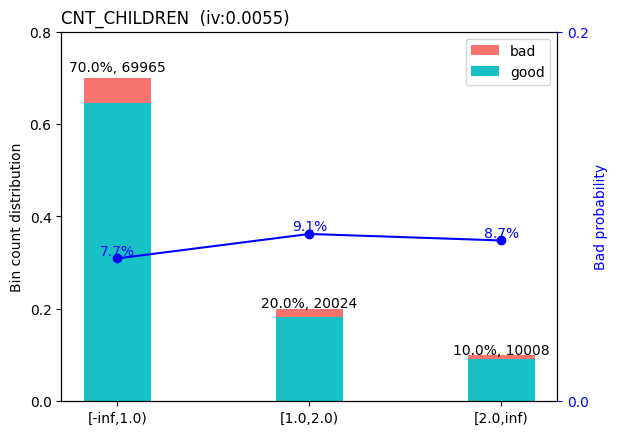

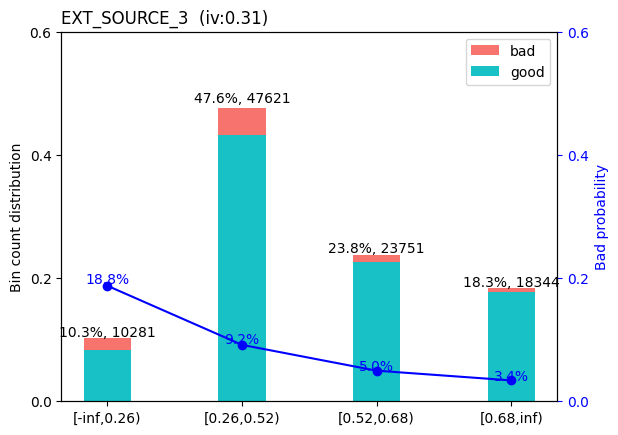

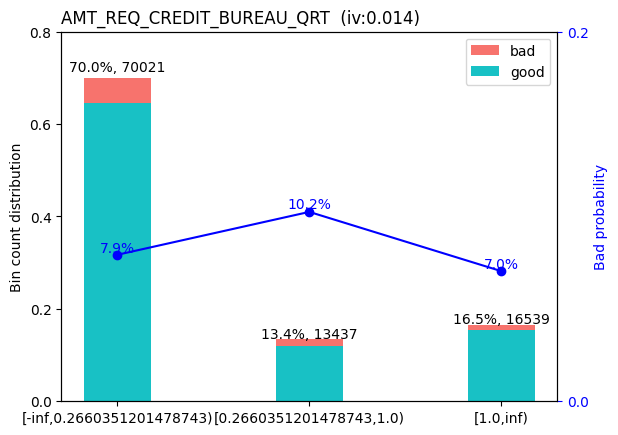

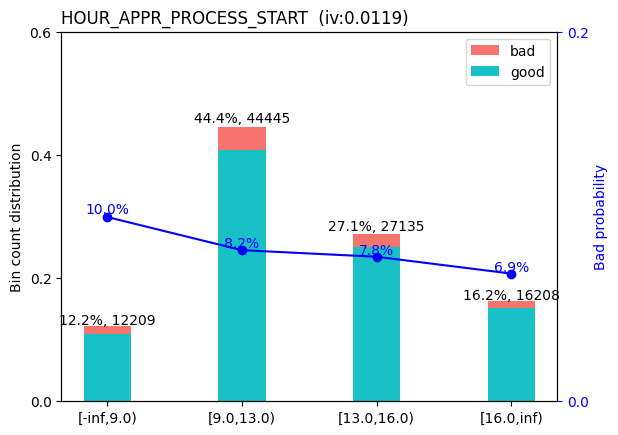

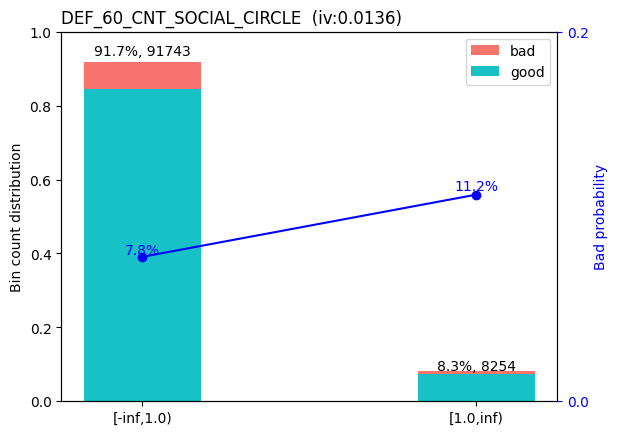

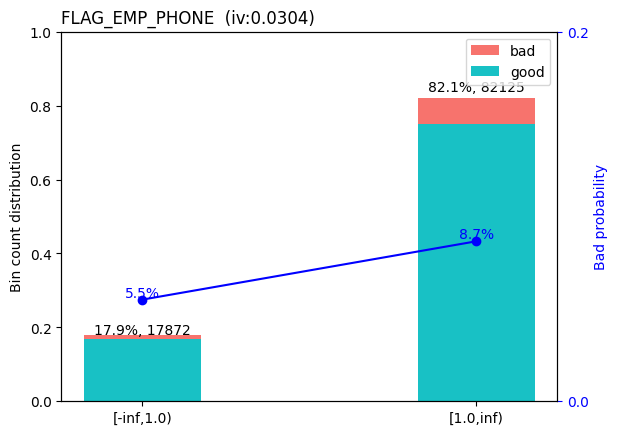

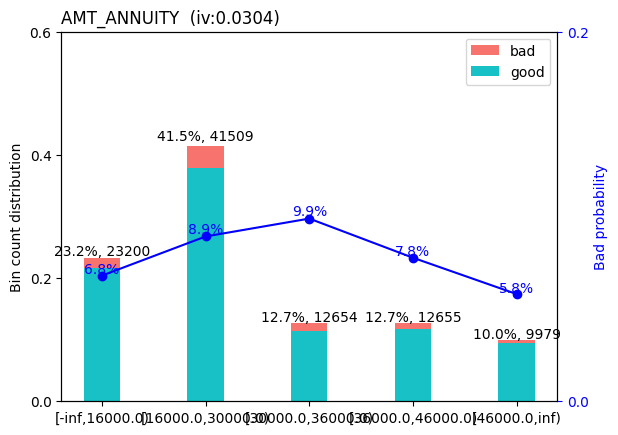

In [13]:
bins = sc.woebin(data.drop(columns = ["SK_ID_CURR"]), y="TARGET")
sc.woebin_plot(bins)

In [14]:
train_woe = sc.woebin_ply(data, bins)
train_woe.drop(columns = ["SK_ID_CURR"], inplace = True)
train_woe.head(10)

[INFO] converting into woe values ...
Woe transformating on 99997 rows and 42 columns in 00:00:16


,TARGET,REGION_RATING_CLIENT_W_CITY_woe,AMT_REQ_CREDIT_BUREAU_WEEK_woe,DAYS_BIRTH_woe,AMT_CREDIT_woe,FLAG_MOBIL_woe,NAME_EDUCATION_TYPE_woe,FLAG_WORK_PHONE_woe,AMT_GOODS_PRICE_woe,REGION_RATING_CLIENT_woe,...,REGION_POPULATION_RELATIVE_woe,AMT_REQ_CREDIT_BUREAU_DAY_woe,NAME_FAMILY_STATUS_woe,CNT_CHILDREN_woe,EXT_SOURCE_3_woe,AMT_REQ_CREDIT_BUREAU_QRT_woe,HOUR_APPR_PROCESS_START_woe,DEF_60_CNT_SOCIAL_CIRCLE_woe,FLAG_EMP_PHONE_woe,AMT_ANNUITY_woe
0,1,-0.017078,-0.049206,0.375621,0.268297,0.0,0.114897,-0.048991,0.294295,-0.020686,...,0.093601,-0.048456,0.241617,-0.049724,0.963608,-0.022477,0.011127,0.357507,0.073559,0.106124
1,0,-0.595849,-0.049206,-0.109913,-0.326531,0.0,-0.448944,-0.048991,-0.312465,-0.617186,...,0.093601,-0.048456,-0.084841,-0.049724,0.135723,-0.022477,0.011127,-0.037964,0.073559,0.219812
2,0,-0.017078,-0.049206,-0.109913,-0.408671,0.0,0.114897,0.178453,-0.307179,-0.020686,...,0.093601,-0.048456,0.241617,-0.049724,-0.919877,-0.022477,0.011127,-0.037964,0.073559,-0.187808
3,0,-0.017078,0.227217,-0.109913,0.268297,0.0,0.114897,-0.048991,0.055469,-0.020686,...,0.093601,0.262087,0.241617,-0.049724,0.135723,0.259758,-0.170826,-0.037964,0.073559,0.106124
4,0,-0.017078,-0.049206,-0.109913,0.268297,0.0,0.114897,-0.048991,-0.052546,-0.020686,...,-0.027226,-0.048456,0.241617,-0.049724,0.135723,-0.022477,0.011127,-0.037964,0.073559,0.106124
5,0,-0.017078,-0.049206,-0.109913,0.268297,0.0,0.114897,0.178453,0.294295,-0.020686,...,-0.243761,-0.048456,-0.084841,-0.049724,-0.521406,-0.150212,-0.170826,-0.037964,0.073559,0.106124
6,0,-0.017078,-0.049206,0.152652,-0.750448,0.0,-0.448944,-0.048991,-0.752524,-0.020686,...,-0.243761,-0.048456,-0.084841,0.122702,0.135723,-0.150212,-0.170826,-0.037964,0.073559,-0.044594
7,0,0.381836,-0.049206,-0.109913,-0.750448,0.0,-0.448944,0.178453,-0.752524,0.354920,...,0.093601,-0.048456,-0.084841,-0.049724,-0.521406,-0.022477,-0.170826,-0.037964,0.073559,-0.044594
8,0,-0.017078,-0.049206,-0.466375,-0.087305,0.0,0.114897,-0.048991,-0.312465,-0.020686,...,0.093601,-0.048456,-0.084841,-0.049724,-0.919877,-0.022477,-0.037292,-0.037964,-0.414064,0.219812
9,0,-0.017078,0.227217,0.152652,0.268297,0.0,0.114897,-0.048991,0.294295,-0.020686,...,0.093601,0.262087,0.241617,-0.049724,0.135723,0.259758,0.228966,-0.037964,0.073559,0.106124


In [ ]:
train_woe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99997 entries, 0 to 99996
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   TARGET                           99997 non-null  int64  
 1   EXT_SOURCE_2_woe                 99997 non-null  float64
 2   NAME_FAMILY_STATUS_woe           99997 non-null  float64
 3   REGION_POPULATION_RELATIVE_woe   99997 non-null  float64
 4   CODE_GENDER_woe                  99997 non-null  float64
 5   DAYS_EMPLOYED_woe                99997 non-null  float64
 6   AMT_REQ_CREDIT_BUREAU_QRT_woe    99997 non-null  float64
 7   AMT_ANNUITY_woe                  99997 non-null  float64
 8   OBS_30_CNT_SOCIAL_CIRCLE_woe     99997 non-null  float64
 9   DAYS_BIRTH_woe                   99997 non-null  float64
 10  NAME_TYPE_SUITE_woe              99997 non-null  float64
 11  DAYS_LAST_PHONE_CHANGE_woe       99997 non-null  float64
 12  AMT_REQ_CREDIT_BUR

In [15]:
X_woe = train_woe.drop(['TARGET'], axis=1)
y_woe = train_woe['TARGET']

X_train_woe, X_test_woe, y_train_woe, y_test_woe = train_test_split(X_woe, y_woe, test_size=0.2, stratify=y_woe, random_state=42)

print("X=",X_train_woe.shape, X_test_woe.shape)
print("y=",y_train_woe.shape, y_test_woe.shape)

X= (79997, 42) (20000, 42)
y= (79997,) (20000,)


In [17]:
names = [
    "Logistic Regression",
    "KNN Classifier",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    "AdaBoost",
]

models = [
    LogisticRegression(random_state=42),
    KNeighborsClassifier(algorithm='auto', leaf_size= 27, n_neighbors= 4, weights= 'distance'),
    DecisionTreeClassifier(criterion ='gini', max_depth = 5, min_samples_leaf= 5,min_samples_split= 2,
                           random_state=42),
    RandomForestClassifier(random_state=42),
    XGBClassifier(),
    AdaBoostClassifier(),
]

In [18]:
def score(X_train, X_test, y_train, y_test, names = names, models = models):
    score_df, score_test = pd.DataFrame(), []
    x = time.time()
    for i, model in enumerate(models):
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        prediction = model.predict_proba(X_test)[:, 1]
        f1 = f1_score(y_test, y_test_pred)
        recall = recall_score(y_test, y_test_pred)
        precision = precision_score(y_test, y_test_pred)
        score_test.append({
            'Classifier': model.__class__.__name__,
            'Accuracy': accuracy_score(y_test, y_test_pred),
            'ROC-AUC': roc_auc_score(y_test, prediction),
            'F1-score': f1,
            'Recall': recall,
            'Precision': precision,
        })

        # Plot ROC-AUC curve for each model
        fpr, tpr, thresholds = roc_curve(y_test, prediction)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(4, 3))
        plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver operating characteristic for {names[i]}')
        plt.legend(loc="lower right")
        plt.show()

    score_df = pd.DataFrame(score_test)
    score_df.sort_values(by='Accuracy', ascending=False, inplace=True)
    print(score_df)

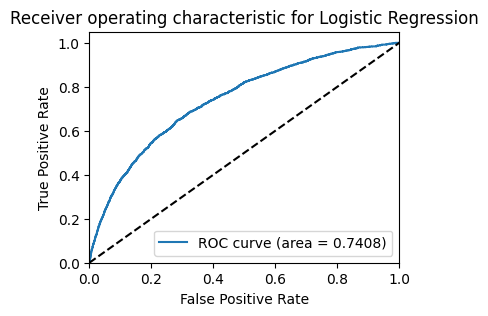

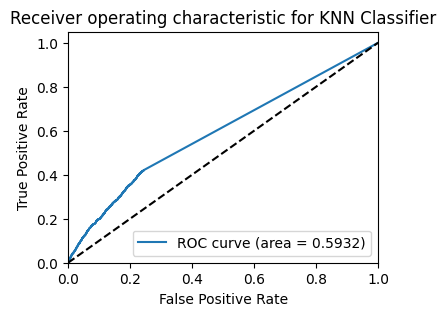

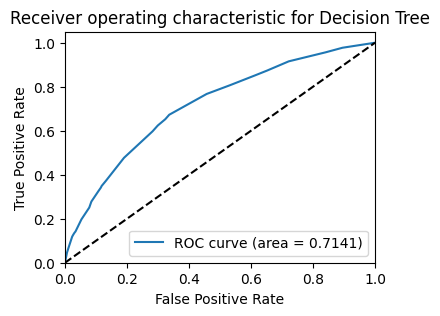

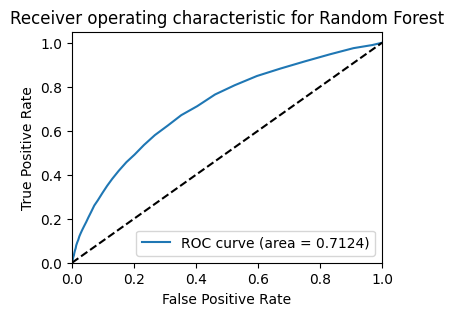

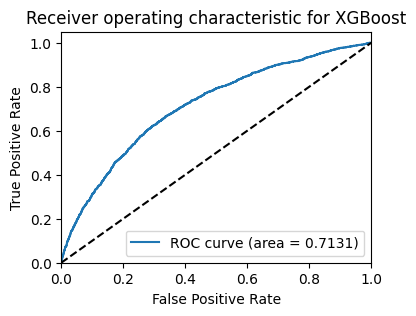

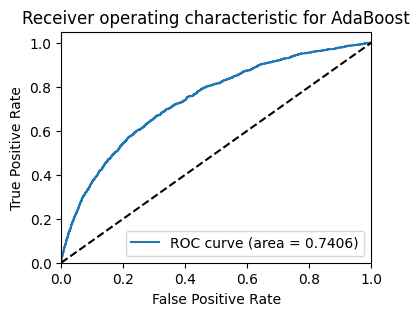

               Classifier  Accuracy   ROC-AUC  F1-score    Recall  Precision
0      LogisticRegression   0.91900  0.740815  0.007353  0.003706   0.461538
2  DecisionTreeClassifier   0.91900  0.714139  0.021739  0.011118   0.486486
3  RandomForestClassifier   0.91875  0.712410  0.003679  0.001853   0.250000
5      AdaBoostClassifier   0.91875  0.740590  0.009750  0.004941   0.363636
4           XGBClassifier   0.91730  0.713142  0.049425  0.026560   0.355372
1    KNeighborsClassifier   0.89945  0.593195  0.098610  0.067943   0.179739


In [19]:
score(X_train_woe, X_test_woe, y_train_woe, y_test_woe, names = names, models = models)